My project task was to determine the number of Opportunity Youth within South King County, and also to breakdown the number of OY by PUMA code within South King County. I am utilizing this notebook to explore the data and determine the best way to do this.

# Plan
- Import required modules and data
- Select columns for analysis
- Deal with missing data
- Find rows that meet requirements to be classified as OY
- Determine number of OY by PUMA code

## Import modules
I need to read in the data from an SQL database so I import psycopg2 to do this. I imported pandas to store data into a dataframe and make it easier to clean. Once I have determined OY per PUMA, I need to graph these findings, so I import matplotlib and set it inline to see plots in the notebook.

In [4]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## Import Data

In [2]:
DBNAME = "opportunity_youth"
conn = psycopg2.connect(dbname=DBNAME)


## Select columns for analysis and store in pandas dataframe
The requirements for OY are that a person must be between the ages of 16 and 24 and disengaged from both work and school.
For this reason I will select the columns that represent age ('agep'), schooling status ('sch'), and work status ('esr').
Along with these three, I will select a few basic columns such as record type, serial number (identifying variable), PUMA code, and state

In [3]:
df = pd.read_sql('''
SELECT rt, serialno, puma, st, agep, sch, esr
FROM pums_2017;
''', conn)

Now that data is stored in the dataframe, I can check for missing values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359075 entries, 0 to 359074
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   rt        359075 non-null  object 
 1   serialno  359075 non-null  object 
 2   puma      359075 non-null  object 
 3   st        359075 non-null  object 
 4   agep      359075 non-null  float64
 5   sch       347443 non-null  object 
 6   esr       291865 non-null  object 
dtypes: float64(1), object(6)
memory usage: 19.2+ MB


I see from this that the only two columns with missing values are 'sch' (school status) and 'esr' (work status).
Looking at the PUMS_data_dictionary document, I see that missing values for 'sch' represent people under the age of 3, who would not be
counted in OY anyways, so I can drop these rows. Looking at that same document, N/A values in the 'esr' columns represent the same thing, 
so I think it's safe to drop those columns as well.

In [6]:
df.dropna(inplace = True)

After dropping rows with missing values, let's check the overview of the data again to make sure everything looks right

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291865 entries, 0 to 359074
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   rt        291865 non-null  object 
 1   serialno  291865 non-null  object 
 2   puma      291865 non-null  object 
 3   st        291865 non-null  object 
 4   agep      291865 non-null  float64
 5   sch       291865 non-null  object 
 6   esr       291865 non-null  object 
dtypes: float64(1), object(6)
memory usage: 27.8+ MB


All the data is accounted for, now I can proceed to analysis of the data

# Data Analysis

The first thing I want to check is the number of people who fall within the required age range (16-24).
To do this, I will utilize the 'agep' column and count how many observations fall within that range.

In [37]:
mask = (
    (df['agep'] >= 16) & 
    (df['agep'] <= 24)
)
len(df[mask])

38170

Now I can see that there are 29,767 people who's age is within that range. Next I want to see how many people are disengaged from both work and school total, regardless of age. To do this I will utilize the 'sch' and 'esr' columns. According to the PUMS_data_dictionary, and 'sch' value of 1 means the individual has not attended school in the past three months. For this initial analysis I am assuming that qualifies as disengaged from school. The data dictionary denotes a value of 3 for the 'esr' column as unemployed and a value of 6 as not in labor force, I will assume those two qualify as disengaged from work.

In [39]:
mask2 = (
    (df['sch'] == '1') &
    ((df['esr'] == '3') | (df['esr'] == '6'))
)
len(df[mask2])

107207

Now I see that there are 107,207 people who disengaged from both work and school. The next thing to do is to combine the age analysis and work and school analysis to see how many people are considered OY.

In [40]:
len(df[mask & mask2])

4488

According to the analysis above there are 3,660 observations in the dataset that can be considered as OY.

## Determine number of OY by PUMA code
The last thing I want to try and do is determine the number of OY in each PUMA code and display this with a plot.


In [18]:
# Create new dataframe with only the observations that are considered OY
oy_df = df[mask & mask2]

In [19]:
# Check that new dataframe has correct number of rows
len(oy_df)

3660

Next I want to find out how many unique PUMA codes there are within this dataframe


In [20]:
len(oy_df['puma'].unique())

56

Okay so there are 56 unique puma codes. I think the best way to visualize this would be with a bar plot. I will have the x-axis be a unique puma code, and the y-axis be the count of observations within that puma code.


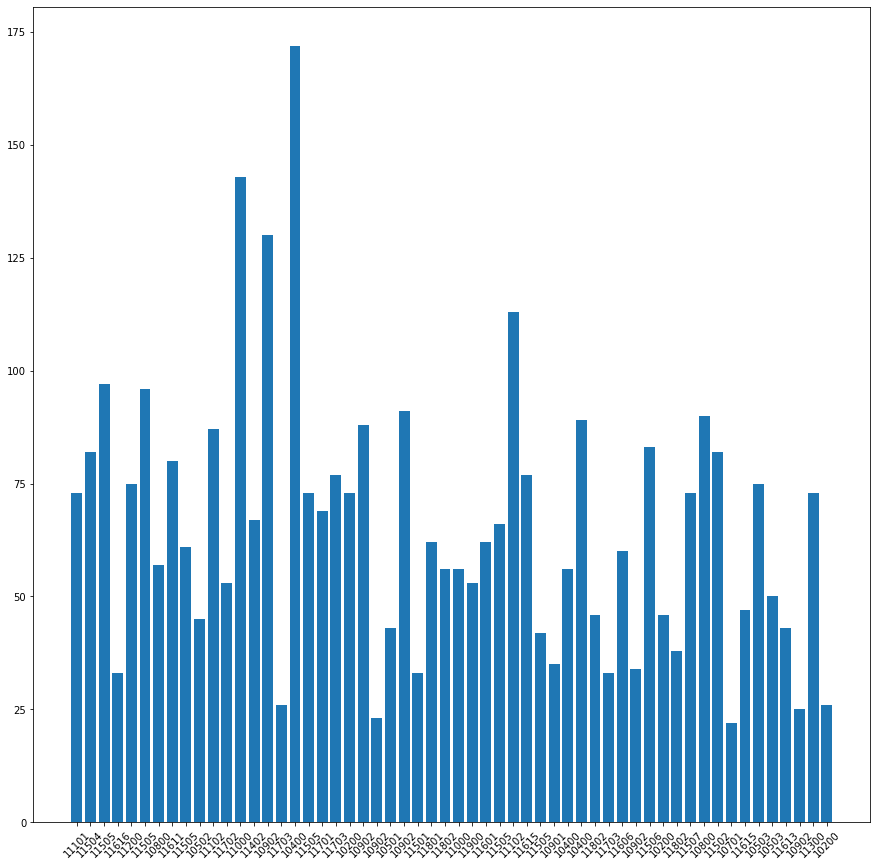

In [27]:
# Create figure
fig, ax = plt.subplots(figsize=(15,15))

# Set x and y axis
x = oy_df['puma']
y = [len(oy_df[oy_df['puma'] == p]) for p in x]

ax.bar(x, y)
ax.set_xticklabels(x, rotation = 45)

plt.show()

Now that we have this, I want to change the 'esr' values that would be considered disengaged from work. At this point, I have 'Unemployed' and 'Not in labor force' as disengaged from work. However, 'Not in labor force' could mean that the individual is self-employed, in which case they are engaged in work. So I want to only consider 'Unemployed' as disengaged

In [41]:
mask2 = (
    (df['sch'] == '1') &
    (df['esr'] == '3')
)
len(df[mask & mask2])

1443

After doing this, I can see that only 1,226 individuals would be considered OY. I think this might actually make more sense. Taking into account that the dataset only represents 5% of the population, and to get a number representative of the entire population I would need to scale this number up by a factor of 20, the initial findings seems to large. 3,660 times 20 is over 70,000 which seems far too large to be accurate. However, 1,226 times 20 is a 22,520 which seems much more reasonable.

Repeating the steps above to plot the OY per PUMA with this new sample seems appropriate.

In [42]:
oy_df2 = df[mask & mask2]

In [43]:
# Check that new dataframe has correct number of rows
len(oy_df2)

1443

Now we can plot the number of OY by PUMA code with new data

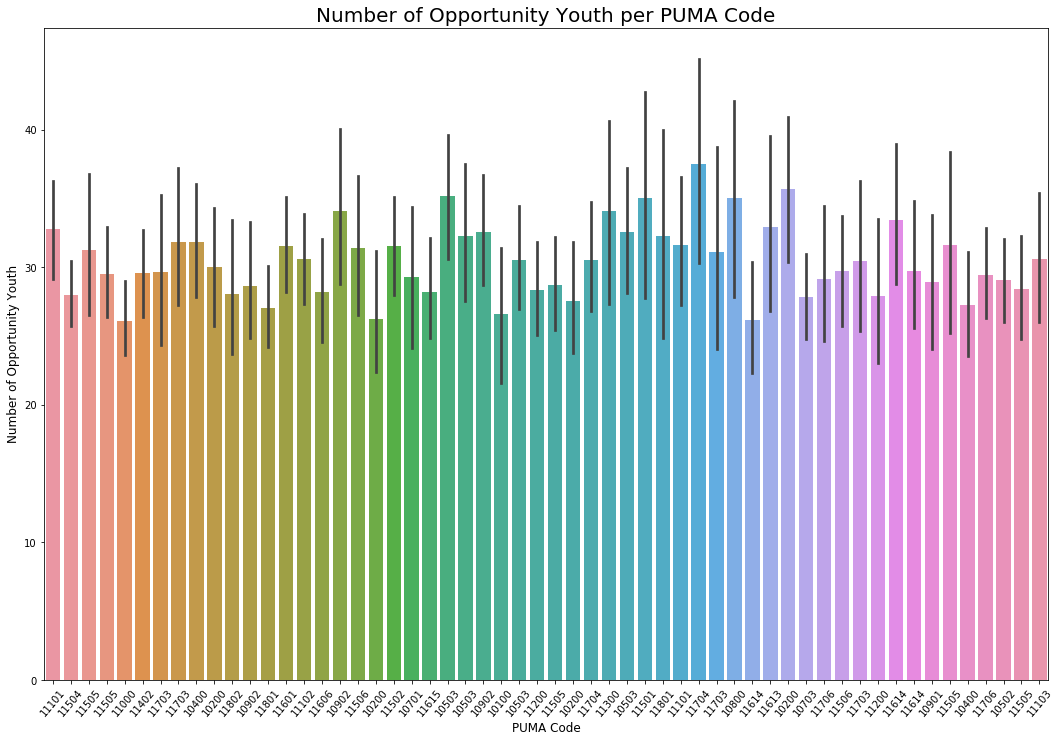

In [135]:
# Create figure
fig, ax = plt.subplots(figsize=(18,12))

# Set x and y axes
x = oy_df2['puma']
y = [len(oy_df2[oy_df2['puma'] == p]) for p in x]

# Create plot
sns.barplot(x, y)

# Add labels
ax.set_title('Number of Opportunity Youth per PUMA Code', fontsize = 20)
ax.set_xlabel('PUMA Code', fontsize = 12)
ax.set_ylabel('Number of Opportunity Youth', fontsize = 12)

# Rotate x-labels to be readable
ax.set_xticklabels(x, rotation = 50)

# Show plot
plt.show()

With some newly given information I think there's one more column I needed for the initial analysis which is the weight column 'pwgtp'

In [80]:
# Recreate original dataframe from beginning of notebook with addition of pwgtp
df = pd.read_sql('''
SELECT rt, serialno, puma, st, pwgtp, agep, sch, esr
FROM pums_2017;
''', conn)

In [81]:
# Drop missing values from sch and esr
df.dropna(inplace=True)

In [82]:
# Check we have correct number of rows
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291865 entries, 0 to 359074
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   rt        291865 non-null  object 
 1   serialno  291865 non-null  object 
 2   puma      291865 non-null  object 
 3   st        291865 non-null  object 
 4   pwgtp     291865 non-null  float64
 5   agep      291865 non-null  float64
 6   sch       291865 non-null  object 
 7   esr       291865 non-null  object 
dtypes: float64(2), object(6)
memory usage: 30.0+ MB


In [83]:
# Recreate OY df from earlier not with pwgtp as column
mask = (
    (df['agep'] >= 16) &
    (df['agep'] <= 24) &
    (df['sch'] == '1') &
    ((df['esr'] == '3') | (df['esr'] == '6'))
)
oy_df = df[mask]

In [84]:
# Make sure oy_df has correct number of rows
len(oy_df)

4488

In [85]:
oy_df.head()

,rt,serialno,puma,st,pwgtp,agep,sch,esr
27,P,2013001209877,11613,53,78.0,24.0,1,6
169,P,2013001213366,11101,53,22.0,22.0,1,3
194,P,2013001213904,11504,53,44.0,21.0,1,3
212,P,2013001214388,11505,53,6.0,24.0,1,6
213,P,2013001214388,11505,53,5.0,22.0,1,3


I just need to figure out how to incorporate the weight column in order to properly scale the number of OY

In [99]:
weights = oy_df['pwgtp']

But before I can do that, I think i need to determine which puma codes are actually within South King County, since the dataset represents all of King County.

In [115]:
skc_pumas = ['11610', '11611', '11612', '11613', '11614', '11615']
total = 0
for index, row in oy_df.iterrows():
    if row['puma'] in skc_pumas:
        total += row['pwgtp']
total

10614.0

Now that I have the South King County PUMA codes, I can once again graph the number of opportunity youth per puma code

In [119]:
# Create dictionary with key as puma code and value as number of OY in that puma code
oy_puma_count = {}
for index, row in oy_df.iterrows():
    if row['puma'] in oy_puma_count:
        oy_puma_count[row['puma']] += row['pwgtp']
    else:
        oy_puma_count[row['puma']] = row['pwgtp']
oy_puma_count

{'11613': 2006.0,
 '11101': 1732.0,
 '11504': 2595.0,
 '11505': 2030.0,
 '11616': 953.0,
 '11200': 2191.0,
 '10800': 2914.0,
 '10504': 1503.0,
 '11611': 2038.0,
 '10300': 1768.0,
 '10502': 2120.0,
 '11102': 1563.0,
 '11103': 1358.0,
 '11702': 1745.0,
 '11000': 2019.0,
 '11402': 1501.0,
 '11503': 2669.0,
 '10200': 3177.0,
 '10902': 3676.0,
 '11703': 1854.0,
 '10400': 2189.0,
 '11701': 1000.0,
 '10501': 2062.0,
 '11802': 2651.0,
 '11501': 2219.0,
 '11801': 2241.0,
 '11900': 1625.0,
 '11601': 657.0,
 '11615': 1210.0,
 '10901': 2954.0,
 '11401': 2940.0,
 '11606': 812.0,
 '11506': 2168.0,
 '11507': 1786.0,
 '11502': 1541.0,
 '10701': 2178.0,
 '10503': 1611.0,
 '11300': 2393.0,
 '10100': 2932.0,
 '11704': 1057.0,
 '11602': 1325.0,
 '11607': 926.0,
 '10703': 2191.0,
 '11614': 1530.0,
 '11605': 908.0,
 '11706': 2113.0,
 '11608': 1086.0,
 '11705': 2222.0,
 '11609': 755.0,
 '11612': 1977.0,
 '10600': 1592.0,
 '10702': 2068.0,
 '11610': 1853.0,
 '11604': 916.0,
 '11104': 1803.0,
 '11603': 1032.0}

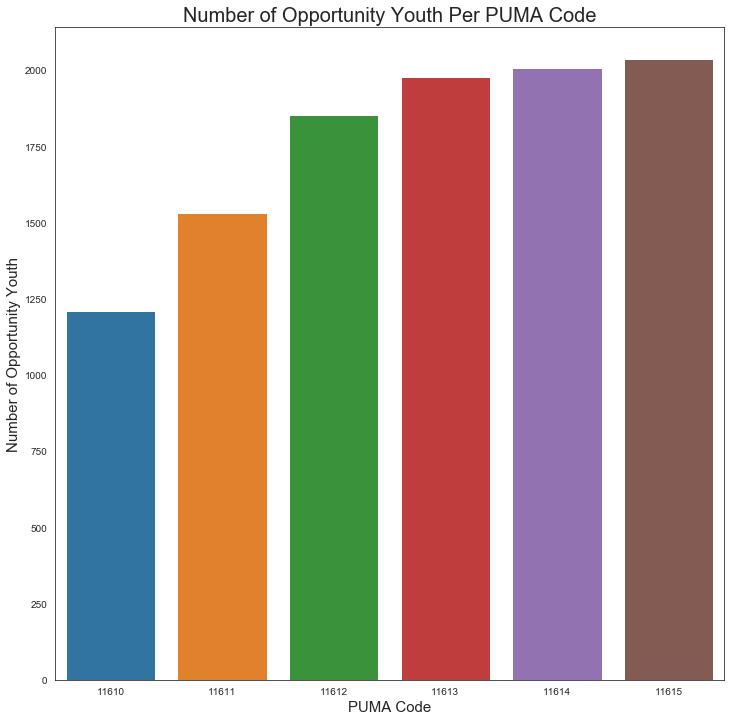

In [142]:
# This time I will use seaborn to make the plot more visually appealing

# Set seaborn style
sns.set_style('white')

# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Set x and y axes
x = skc_pumas
y = [p[1] for p in oy_puma_count.items() if p[0] in skc_pumas]

# Sort y-values
y.sort()

# Plot with seaborn
sns.barplot(x, y)

# Set title and labels
ax.set_title('Number of Opportunity Youth Per PUMA Code', fontsize=20)
ax.set_xlabel('PUMA Code', fontsize=15)
ax.set_ylabel('Number of Opportunity Youth', fontsize=15);


# Choropleth Map

Now that the above tasks are completed (in subject notebook), I want to attempt to create a choropleth map of the count of OY by puma in South King County

In [1]:
import geopandas as gpd

I need to read in a shape file, hopefully the xml version will work

In [20]:
gdf = gpd.read_file('./../../src/data/parcel_address')

In [22]:
gdf.shape

(622273, 63)